## Packages Import and global model variable assignment
Also fetch local openAI api key

In [5]:
import pandas as pd
import numpy as np
import os
import openai as ai
import xgboost as xgb
import sklearn as sl


ai.api_key = os.environ.get('AI_API_KEY')


## Data Download and Cleaning

In [1]:
from functions import downloadData

path = (r'C:\Users\Luke\Downloads\reviews_Electronics_5.json')

data = downloadData(path = path, n = 100000)

In [7]:
data.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"


In [2]:
from functions import transformData

transformed_data = transformData(data = data)

In [9]:
transformed_data.head(3)

,overall,helpful_ratio,overall_positive,excellent,good,great,impressive,satisfactory,outstanding,fantastic,...,troublesome,detestable,abominable,repugnant,lamentable,revolting,displeasing,dismaying,termination,apprehensive
0,4,0.00,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0.93,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Data Exploration
Data distribution has very uneven classes, so will need to address in the decision trees.

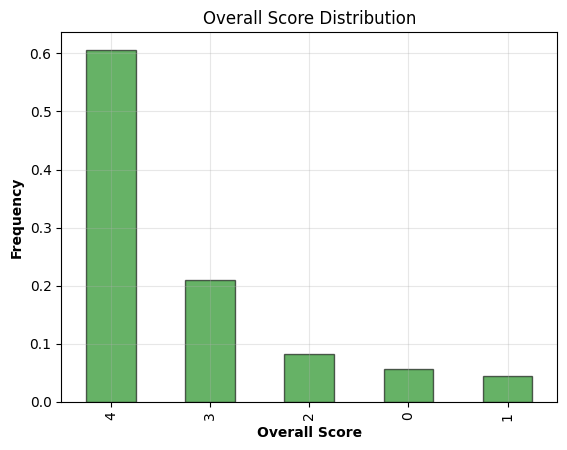

In [10]:
from utils import frequencyHistogram

frequencyHistogram("overall", transformed_data)

## Modelling and Cross Validation
We go over the binary GBM, score GBM, binary GPT, and score GPT

In [5]:
response_var_binary = transformed_data['overall_positive']
response_var = transformed_data['overall']
predictor_var = transformed_data.drop(['overall_positive', 'overall'], axis = 1)

**Binary GBM**

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

X_train_binary, X_test_binary, Y_train_binary, Y_test_binary = train_test_split(predictor_var, response_var_binary, test_size=0.1, random_state=42)

xgb_classifier = XGBClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs = -1)

grid_search.fit(X_train_binary, Y_train_binary)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


In [9]:
from xgboost import XGBClassifier

#Dataset is unbalnced so we need to adjust weights in scale_pos_weight to account for probabibalistic bias to positive.
model_binary = XGBClassifier(objective = 'binary:logistic', eval_metric = 'rmse', n_estimators = 1000, learning_rate = 0.05, max_depth = 5, colsample_bytree = 1, subsample = 0.9, scale_pos_weight = (100000-sum(Y_train_binary)) / sum(Y_train_binary))

model_binary.fit(X_train_binary, Y_train_binary)
predictions_binary = model_binary.predict(X_test_binary)

**Binary ChatGPT**

First we set up the test dataframe and predictions dataframe

In [14]:
#We need to join reviewText and summary as these are the predictors for chat GPT.
X_test_binary_gpt = X_test_binary.join(data[['reviewText',"summary"]])

predictions_binary_gpt_df = pd.DataFrame(columns=['prediction_binary', 'prediction'])

In [71]:
from functions import fetchGPT

#We need to run this multiple times until all prompts predicted.

X_test_binary_gpt, predictions_binary_gpt_df = fetchGPT(X_test_binary_gpt, predictions_binary_gpt_df, Y_test_binary)

#Only use predictions when we have all of them computed.
predictions_binary_gpt = predictions_binary_gpt_df['prediction_binary'].to_list() if len(Y_test_binary) == len(predictions_binary_gpt_df) else None



Done. 1000 predictions ready.


**Score GBM**

In [77]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, Y_train, Y_test = train_test_split(predictor_var, response_var, test_size=0.1, random_state=42)

xgb_classifier = XGBClassifier(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs = -1)

grid_search.fit(X_train, Y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


In [12]:
from xgboost import XGBClassifier
from sklearn.utils import class_weight

model = XGBClassifier(objective = 'binary:logistic', eval_metric = 'rmse', n_estimators = 1000, learning_rate = 0.05, max_depth = 5, colsample_bytree = 0.8, subsample = 0.8)

#Dataset is unbalnced so we need to adjust weights in sample_weight to account for probabibalistic bias to positive.
weights_class = class_weight.compute_class_weight(class_weight = 'balanced', classes = [0,1,2,3,4], y = Y_train)
#Assigns weights to each sample observation.
weights = Y_train.apply(lambda row: weights_class[row])

model.fit(X_train, Y_train, sample_weight=weights)
predictions = model.predict(X_test)

**Score ChatGPT**

In [79]:
#We need to join reviewText and summary as these are the predictors for chat GPT.
X_test_gpt = X_test.join(data[['reviewText',"summary"]])

predictions_gpt_df = pd.DataFrame(columns=['prediction_binary', 'prediction'])

In [134]:
from functions import fetchGPT

#We need to run this multiple times until all promps predicted.

X_test_gpt, predictions_gpt_df = fetchGPT(X_test_gpt, predictions_gpt_df, Y_test)

#Only use predictions when we have all of them computed.
predictions_gpt = predictions_gpt_df['prediction'].to_list() if len(Y_test) == len(predictions_gpt_df) else None


Done. 1000 predictions ready.


## Model Diagnostics
**Binary GBM**

In [10]:
from utils import accuracy

accuracy(Y_test_binary, predictions_binary)

Accuracy: 0.8562
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.59      0.49      1180
           1       0.94      0.89      0.92      8820

    accuracy                           0.86     10000
   macro avg       0.68      0.74      0.70     10000
weighted avg       0.88      0.86      0.87     10000



In [14]:
from utils import confusionMatrix

confusionMatrix(Y_test_binary, predictions_binary)

Confusion Matrix:

False Positives: 484
False Negatives: 954
True Positives: 7866
True Negatives: 696


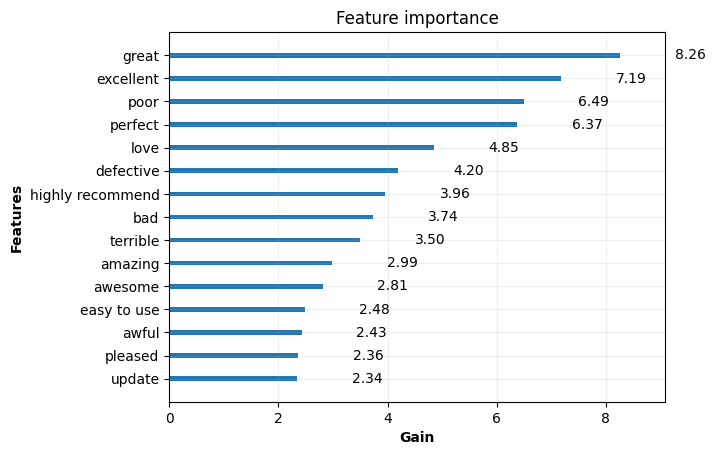

In [97]:
from utils import importance

importance(model_binary)
   

**Chat GPT Binary**

In [96]:
from utils import accuracy

accuracy(Y_test_binary, predictions_binary_gpt)

Accuracy: 0.947
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.69      0.70        91
           1       0.97      0.97      0.97       909

    accuracy                           0.95      1000
   macro avg       0.84      0.83      0.84      1000
weighted avg       0.95      0.95      0.95      1000



In [95]:
from utils import confusionMatrix

confusionMatrix(Y_test_binary, predictions_binary_gpt)

Confusion Matrix:

False Positives: 28
False Negatives: 25
True Positives: 884
True Negatives: 63


**Score GBM**

In [13]:
from utils import accuracy

accuracy(Y_test, predictions)

Accuracy: 0.4673
Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.54      0.35       684
           1       0.13      0.21      0.16       496
           2       0.13      0.24      0.17       806
           3       0.32      0.34      0.33      2036
           4       0.81      0.55      0.66      5978

    accuracy                           0.47     10000
   macro avg       0.33      0.38      0.33     10000
weighted avg       0.59      0.47      0.51     10000



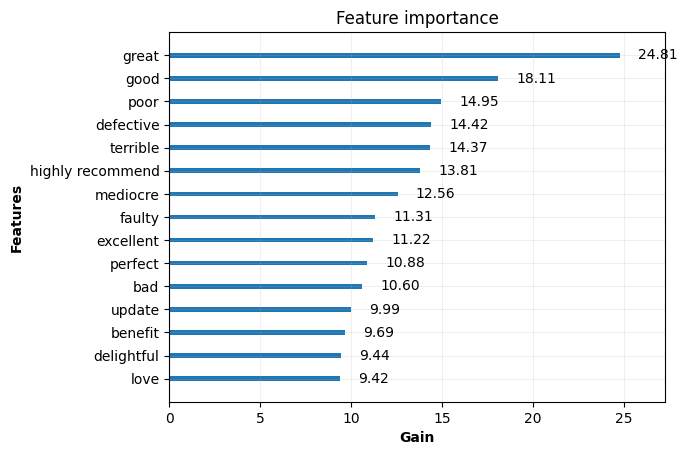

In [ ]:
from utils import importance

importance(model)
   

**Chat GPT Score**

In [135]:
from utils import accuracy

accuracy(Y_test, predictions_gpt)

Accuracy: 0.569
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.35      0.49        55
           1       0.27      0.47      0.35        36
           2       0.47      0.46      0.46        85
           3       0.33      0.71      0.45       207
           4       0.90      0.56      0.69       617

    accuracy                           0.57      1000
   macro avg       0.57      0.51      0.49      1000
weighted avg       0.72      0.57      0.60      1000

